# Модель для определения вида продукции по его текстовому описанию

Создадим модель, обрабатывающую фрагмент текста и определяющую
какой вид продукции в нём содержится.

## Подготовка данных

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import torch
import transformers

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from optuna.samplers import TPESampler
from tqdm import notebook
from transformers import AutoTokenizer, AutoModel

Откроем датасет

In [ ]:
try:
  data = pd.read_csv('/content/drive/MyDrive/datasets/meatinfo.csv', sep=';')
except:
  data = pd.read_csv('/content/drive/MyDrive/datasets/meatinfo.csv', sep=';')

data.head(5)

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17893 entries, 0 to 17892
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17893 non-null  object
 1   mtype   17892 non-null  object
dtypes: object(2)
memory usage: 279.7+ KB


Изменим тим данных в столбце mtype на категориальный.

In [ ]:
data['mtype'] = data['mtype'].astype('category')

Избавимся от пропусков

In [ ]:
data = data.dropna()

In [ ]:
data[data.duplicated()]

,text,mtype
5689,"Говядина 1 кат. П/т охл коровы В наличие, Рос...",Говядина
7705,Выгодное Предложение! Курица Цб 82р/кг Наша ко...,Кура
15236,печень говяжья,Говядина
17271,Реализуем охлаждённое мясо свинины Торговый до...,Свинина


Избавимся от дубликатов

In [ ]:
data = data.drop_duplicates()

Посмотрим на распределение значений в столбце mtype

In [ ]:
data['mtype'].value_counts()

Говядина                                                                                   8420
Свинина                                                                                    3049
Кура                                                                                       1570
Индейка                                                                                    1337
Баранина                                                                                   1116
Цыпленок                                                                                    942
Кролик                                                                                      334
Утка                                                                                        195
Оленина                                                                                     193
Конина                                                                                      176
Гусь                                    

Исправим ошибки в наименованиях

In [ ]:
data.loc[data['mtype'] == 'Говядина, полутуши, 1 категория,  охл., Россия, подвес, В наличии, 10 тонн, 270 руб. кг', 'mtype'] = 'Говядина'

In [ ]:
data.loc[data['mtype'] == 'свиниеа'] = 'Свинина'

Уберём пробелы в начале наименований

In [ ]:
data.loc['mtype'] = data['mtype'].str.lstrip()

Сделаем так, чтобы наименования начинались с заглавной буквы

In [ ]:
data.loc['mtype'] = data['mtype'].str.capitalize()

Для редких наименований создадим наименование 'Другое'

In [ ]:
food_count = data['mtype'].value_counts()

In [ ]:
data['mtype'] = data['mtype'].apply(lambda x: 'Другое' if food_count[x] < 500 else x)

Объединим наименования 'Кура' и 'Цыпленок'

In [ ]:
data.loc[data['mtype'] == 'Кура'] = 'Цыпленок'

Уберём из датасета строки с наименованием 'Другое'

In [ ]:
data = data.loc[data['mtype'] != 'Другое']

In [ ]:
data['mtype'].value_counts()

Говядина    8421
Свинина     3050
Цыпленок    2512
Индейка     1337
Баранина    1116
Name: mtype, dtype: int64

Уберём из описания символы, не являющиеся кириллицей

In [ ]:
data['text'] = data['text'].replace('[^а-яА-ЯёЁ ]', '', regex=True)

In [ ]:
data['text'] = data['text'].astype(str)

Посмотрим как распределены длины текстов в описании

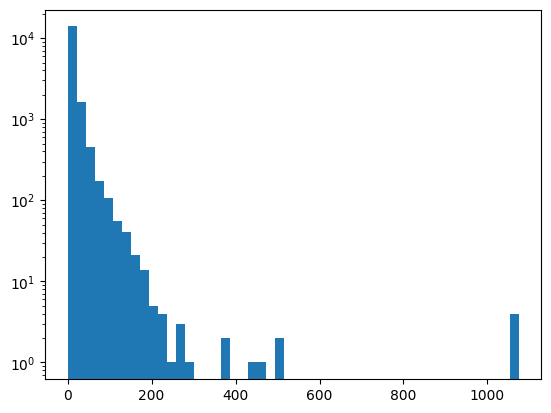

In [ ]:
train_lens = [len(i.split()) for i in data['text']]
plt.yscale('log')
plt.hist(train_lens, bins=50);

Большинство описаний достаточно короткие, но есть и очень большие

Создадим колонку с длиной текста описания

In [ ]:
data['len'] = data['text'].apply(lambda x: len(x.split()))

In [ ]:
data.drop(data.tail(1).index,inplace=True)

Посмотрим на тексты длиной более 1000

In [ ]:
data[data['len'] >= 1000]

,text,mtype,len
1732,грудинка ИВР от производителя зам ГРУДИНКА ИВР...,Свинина,1062
11033,Корейка свиная на кости Воронежский беконТелКО...,Свинина,1066
13720,набор для борща фасов от производителя Свинина...,Свинина,1059
14197,ножки свиные задние от производителя Воронежск...,Свинина,1074


Данные тексты содержат описания сразу для нескольких категорий товаров, исключим их из датасета.

In [ ]:
data = data.loc[data['len'] <= 1000]

## Создание эмбеддингов текстов

Для создания эмбеддингов воспользуемся готовым энкодером предложений 'rubert-tiny2'

In [ ]:
pretrained_weights = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
model = AutoModel.from_pretrained(pretrained_weights)

Токенизируем описания текстов

In [ ]:
%%time
tokenized = data['text'].apply(lambda x: tokenizer(x, padding=True, truncation=True))

CPU times: user 2.11 s, sys: 62.3 ms, total: 2.17 s
Wall time: 2.17 s


Посмотрим на максимальную длину токенизированного текста

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i['input_ids']) > max_len:
        max_len = len(i['input_ids'])
max_len

904

Добавим пэддинг для элементов меньшей длины

In [ ]:
padded = np.array([i['input_ids'] + [0]*(max_len - len(i['input_ids'])) for i in tokenized.values])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)

Создадим пэддинги с помощью pytorch

In [ ]:
%%time
batch_size = 10
embeddings = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
        try:
          batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
          attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        except:
          batch = torch.LongTensor(padded[batch_size*i:])
          attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:])

        with torch.no_grad():
            batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/1644 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 1.66 s, total: 1min 37s
Wall time: 1min 56s


Сохраним эмбеддинги в файл.

In [ ]:
np.savetxt(fname="embeddings.csv", delimiter=";", X=embeddings, fmt='%s')

## Построение модели

Создадим фичи из эмбеддингов и выделим признаки из датасета

In [ ]:
features = np.concatenate(embeddings)
target = data['mtype']

Выделим из датасета тестовую выборку

In [ ]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.2, stratify=target)

Зададим сеть гиперпараметров для оптимизации

In [ ]:
def objective(trial):

    X_train, X_valid, y_train, y_valid = \
    train_test_split(features_train, target_train, test_size=0.25, stratify=target_train)

    params = {
        'task_type':'GPU',
        'objective': 'MultiClass',
        'loss_function': 'MultiClass',
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "used_ram_limit": "10gb",
        "verbose": False
    }

    cat_model = CatBoostClassifier(**params)

    trial.set_user_attr(key="best_booster", value=cat_model)

    cat_model.fit(features_train, target_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)

    preds = cat_model.predict(X_valid)
    score = f1_score(y_valid, preds, average='macro')

    return score

Создадим колбэк для сохранения лучшей модели

In [ ]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

Проведём поиск гиперпараметров с помощью optuna.

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

cat_study = optuna.create_study(study_name="catboost", direction="maximize", sampler=TPESampler())
cat_study.optimize(objective, n_trials=100,
                   #callbacks=[callback],
                   timeout=7200
                   )
best_cat_model = cat_study.user_attrs["best_booster"]

KeyError: ignored

"""
Тут я забыл раскоментить 'callbacks=[callback]', поэтому лучшая модель не сохранилась, и нужно будет повторно её обучить с полученными параметрами.
"""

Посмотрим на результаты оптимизации.

In [ ]:
print("Number of finished trials: ", len(cat_study.trials))
print("Best trial:")
trial = cat_study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  43
Best trial:
  Value:  1.0
  Params: 
    iterations: 1461
    learning_rate: 0.10812802151407475
    l2_leaf_reg: 0.00010350794109738761
    depth: 8


In [ ]:
optuna.visualization.plot_optimization_history(cat_study)

На большом наборе гиперпараметров модель показывает хорошие результаты.

In [ ]:
optuna.visualization.plot_param_importances(cat_study)

Наибольшее влияние среди гиперпараметров на модель оказывает коэффициент регуляризации функции потерь L2.

Обучим модель с найденными гиперпараметрами.

In [ ]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(features_train, target_train, test_size=0.25, stratify=target_train)

In [ ]:
best_params = {
        'task_type':'GPU',
        'objective': 'MultiClass',
        'loss_function': 'MultiClass',
        'iterations': 1461,
        'learning_rate': 0.10812802151407475,
        'l2_leaf_reg': 0.00010350794109738761,
        "depth": 8,
        "used_ram_limit": "10gb",
        "verbose": False
    }

best_cat_model = CatBoostClassifier(**best_params)

best_cat_model.fit(features_train, target_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)

In [ ]:
best_cat_model.save_model('cb_model.cbm')

Изучим как точно модель выявляет признаки.

In [ ]:
print(classification_report(target_test, best_cat_model.predict(data=features_test), digits=5))

              precision    recall  f1-score   support

    Баранина    0.99468   0.83857   0.90998       223
    Говядина    0.93307   0.97626   0.95418      1685
     Индейка    0.99200   0.92884   0.95938       267
     Свинина    0.85133   0.89327   0.87179       609
    Цыпленок    0.97763   0.86879   0.92000       503

    accuracy                        0.93124      3287
   macro avg    0.94974   0.90114   0.92307      3287
weighted avg    0.93371   0.93124   0.93111      3287



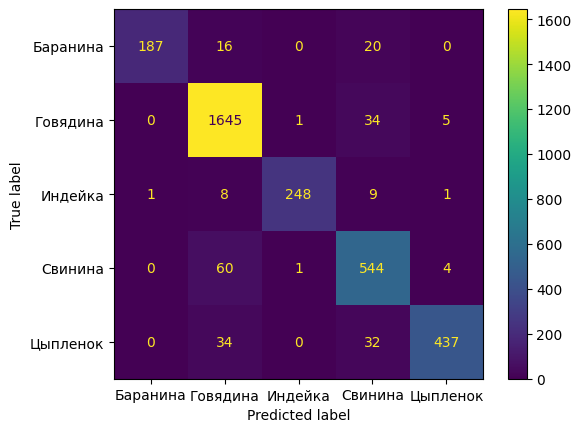

In [ ]:
cm = confusion_matrix(target_test, \
                      best_cat_model.predict(data=features_test), labels=best_cat_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_cat_model.classes_)
disp.plot()
plt.show()

Говядина и индейка выявляются максимально точно, больше всего проблем с выявлением баранины, наибольшая доля неправильных прогнозов приходится на свинину.

## Проверка модели

In [ ]:
def get_predictions(cat_model, test_cases):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  pretrained_weights = 'cointegrated/rubert-tiny2'
  tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
  model = AutoModel.from_pretrained(pretrained_weights)

  tokenized_test = [tokenizer(i, padding=True, truncation=True) for i in test_cases]
  max_len = 0
  for i in tokenized_test:
    if len(i['input_ids']) > max_len:
      max_len = len(i['input_ids'])

  padded = np.array([i['input_ids'] + [0]*(max_len - len(i['input_ids'])) for i in tokenized_test])
  attention_mask = np.where(padded != 0, 1, 0)

  batch_size = 10
  embeddings = []


  model = model.to(device)

  for i in range(padded.shape[0] // batch_size + 1):
    try:
      batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
      attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    except:
      batch = torch.LongTensor(padded[batch_size*i:])
      attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:])

    with torch.no_grad():
      batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    predictions = []
    for i in embeddings:
      predictions.append(cat_model.predict(data=i))

    return predictions


Проверим модель на указанных примерах

In [ ]:
test_cases = [
    'Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20)\nСвободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.',
    'Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:',
    'Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.'
]

In [ ]:
predicted_cases = get_predictions(best_cat_model, test_cases)

In [ ]:
for i in predicted_cases:
  print(i)

[['Говядина']
 ['Цыпленок']
 ['Говядина']]


Для выбранных примеров классификация проведена верно.

## Выводы по проделанной работе:
1. Для обучения модели были исправлены неточности в целевых признаках и были выбраны те, которые встречаются в датасете.
1. Для обучения моделей текстовые описания были очищены от всех символов кроме кириллицы и пробелов, возможно для улучшения качества модели можно будет также очищать описания от не информативных слов и аббревиатур (ООО, ЦБ, ТЕЛ и т.п.)
1. C помощью pytorch были получены эмбеддинги текстовых описаний и сохранены в отдельный датасет для возможной экономии вычислительных ресурсов.
1. На эмбединнгах была обучена модель классификации catboost и оптимизирована с помощью optuna (модель также сохранена)
1. Был проведён анализ результатов обученной модели на тестовой выборке, моедль показала удовлетворительные результаты.
1. Было проведено тестирование модели на трёх тестовых текстах, на всех трёх модель дала правильные прогнозы.